In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import nltk
nltk.download('punkt')
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm

[nltk_data] Downloading package punkt to /home/pk36/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## CatE Helper Functions ##

In [2]:
def readCateEmbeddings(filename):
    emb = {}
    with open(filename, 'r') as infile:
        vectors = infile.readlines()[1:]
        for v in vectors:
            token,cate_emb = v.strip().split(' ', 1)
            cate_emb = cate_emb.split(' ')
            emb[token] = np.array(cate_emb)
            emb[token] = emb[token].astype(np.float64)
    return emb

In [3]:
def readCateSpec(filename):
    spec = {}
    with open(filename, 'r') as infile:
        temp = infile.readlines()[1:]
        for s in temp:
            token,specificity = s.strip().split(' ')
            spec[token] = float(specificity)
    return spec

## Compute Reciprocal Entropy Per Word Over Doc and Corpus ##

In [66]:
def tf_idf(df):
    numdoc = df.groupby(by="words").size()
    metric = []
    print("Computing tf-idf...")
    for i, token in enumerate(tqdm(df["words"].values)):
        metric.extend([df["count"].values[i] * np.log(len(corpus)/float(numdoc.loc[token]))])
        
    df["tf_idf"] = metric
    return df

In [69]:
def calcRecEntropy(corpus):
    ent_df = pd.DataFrame()
    w = [] # word
    c = [] # count
    p = [] # probability within doc
    # dataframe w/ words and count for each document
    for doc in tqdm(corpus):
        data = nltk.word_tokenize(doc) 
        counter = Counter(data)
        df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
        df = df.rename(columns={"index": "words", 0: "count"})
        w.extend(df["words"].values)
        c.extend(df["count"].values)
        p.extend(df["count"].values/float(len(data)))
    
    ent_df["words"] = w
    ent_df["count"] = c
    ent_df["doc_prob"] = p
    ent_df["num_docs"] = np.ones(len(ent_df))
    # compute tf-idf for each of the words and average for each unique word
    ent_df = tf_idf(ent_df)
    # compute entropy & reciprocal entropy
    ent_df = ent_df.groupby(by="words").agg({'count' : 'sum', 'doc_prob' : 'mean', 'tf_idf' : 'mean'})
    ent_df["prob"] = ent_df['count'] / float(len(w)) # probability across entire corpus
    
    ent_df["entropy"] = (ent_df["prob"]*np.log(1/ent_df["prob"]))
    ent_df['reciprocal_entropy'] = 1/ent_df["entropy"]
    
    ent_df["doc_entropy"] = (ent_df["doc_prob"]*np.log(1/ent_df["doc_prob"]))
    ent_df['doc_rep_entropy'] = 1/ent_df["doc_entropy"]
    
    return ent_df

In [91]:
corpus = []
with open('/shared/data2/pk36/multidim/cate_data/covid/covid_phrase_text_v2.txt') as infile:
    corpus = list(infile.readlines())
del corpus[15555] #italian

In [93]:
ent_df = calcRecEntropy(corpus)

100%|█████████████████████████████████████| 28599/28599 [06:33<00:00, 72.74it/s]


Computing tf-idf...


100%|████████████████████████████| 15912198/15912198 [03:56<00:00, 67359.44it/s]


## Top Words w/ Highest Reciprocal Entropy (expected more rare) ##

In [94]:
ent_df.sort_values(by="reciprocal_entropy", ascending = False).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
zzzproportion,1,0.000218,10.261127,6.284487e-08,0.000001,959572.161022,0.001841,543.228360
farmington,1,0.000076,10.261127,6.284487e-08,0.000001,959572.161022,0.000722,1385.859613
farlow,1,0.000081,10.261127,6.284487e-08,0.000001,959572.161022,0.000765,1307.427969
ratione,1,0.000207,10.261127,6.284487e-08,0.000001,959572.161022,0.001757,569.088792
farmac,1,0.000161,10.261127,6.284487e-08,0.000001,959572.161022,0.001408,710.108703
farmaceutici,1,0.000015,10.261127,6.284487e-08,0.000001,959572.161022,0.000171,5838.277700
farmaceutiska,1,0.000514,10.261127,6.284487e-08,0.000001,959572.161022,0.003895,256.718288
farmacocin,1,0.000119,10.261127,6.284487e-08,0.000001,959572.161022,0.001075,930.600367
farmacodin,1,0.000119,10.261127,6.284487e-08,0.000001,959572.161022,0.001075,930.600367


In [95]:
ent_df.sort_values(by="doc_rep_entropy", ascending = False).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
keang,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a464,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
hyunna,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a460,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a461,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a462,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
austroglyciphagous,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a463,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264
a465,1,0.000005,10.261127,6.284487e-08,0.000001,959572.161022,0.000056,17986.162264


## Bottom Words w/ Lowest Reciprocal Entropy (expected less rare) ##

In [96]:
ent_df.sort_values(by="reciprocal_entropy", ascending = True).head(15)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
",",3432292,0.046457,5.108291,0.215702,0.330856,3.022462,0.142588,7.013219
the,3282757,0.048131,3.097799,0.206304,0.325631,3.070957,0.146022,6.848291
.,3186144,0.044639,4.443846,0.200233,0.322029,3.105307,0.138789,7.205170
of,2294321,0.038334,2.080221,0.144186,0.279238,3.581171,0.125023,7.998552
and,1920938,0.030871,2.508639,0.120721,0.255237,3.917923,0.107367,9.313857
in,1564320,0.025055,2.399598,0.098309,0.228042,4.385155,0.092371,10.825911
),1417519,0.019995,6.566066,0.089084,0.215420,4.642085,0.078226,12.783470
(,1409290,0.019866,6.559658,0.088567,0.214686,4.657975,0.077851,12.845054
to,1230128,0.019184,2.831433,0.077307,0.197904,5.052954,0.075848,13.184319


In [97]:
ent_df.sort_values(by="doc_rep_entropy", ascending = True).head(15)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
mondialisation,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
123847,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
nett,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
rollercoaster,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
transplantion,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
delhi_india,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
incertitudes,1,0.125000,10.261127,6.284487e-08,0.000001,959572.161022,0.259930,3.847187
file_server,12,0.115741,7.776220,7.541384e-07,0.000011,94059.133805,0.249584,4.006673
misadventures,1,0.111111,10.261127,6.284487e-08,0.000001,959572.161022,0.244136,4.096077


## Comparing Terms with High vs. Low TF-IDF Scores ##

In [98]:
ent_df.sort_values(by="tf_idf", ascending = False).head(10) # most of these are in Italian.
# they were, also, state, in, they have, etc...

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
taar1,246,0.024268,2524.237250,0.000015,0.000171,5839.323305,0.090242,11.081359
bzip60,518,0.017714,2478.106781,0.000033,0.000336,2972.965723,0.071447,13.996368
biochar,468,0.011468,2238.907285,0.000029,0.000307,3258.578223,0.051242,19.515323
cphv,217,0.027296,2226.664566,0.000014,0.000153,6545.574432,0.098292,10.173741
a51r,202,0.015859,2072.747660,0.000013,0.000143,6986.957583,0.065721,15.215848
kre2p,180,0.016613,1847.002866,0.000011,0.000129,7761.536132,0.068072,14.690242
3d8_scfv,179,0.019471,1836.741739,0.000011,0.000128,7801.080905,0.076694,13.038841
hire1a_cld,177,0.013629,1816.219485,0.000011,0.000127,7881.457322,0.058544,17.081120
cat_2_virsorter_node,176,0.016007,1805.958357,0.000011,0.000126,7922.303213,0.066185,15.109055


In [99]:
ent_df.sort_values(by="tf_idf", ascending = True).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
of,2294321,0.038334,2.080221,0.144186,0.279238,3.581171,0.125023,7.998552
26,20445,0.000577,2.309078,0.001285,0.008553,116.911650,0.004303,232.417708
27,20624,0.000616,2.341399,0.001296,0.008617,116.048908,0.004556,219.483052
19,25365,0.000723,2.361127,0.001594,0.010268,97.389078,0.005230,191.189127
29,19652,0.000568,2.382977,0.001235,0.008271,120.910782,0.004242,235.741311
here,19208,0.001947,2.386445,0.001207,0.008111,123.284971,0.012151,82.299711
23,23503,0.000647,2.388500,0.001477,0.009627,103.875141,0.004751,210.477936
31,18726,0.000572,2.392643,0.001177,0.007938,125.981802,0.004272,234.061331
in,1564320,0.025055,2.399598,0.098309,0.228042,4.385155,0.092371,10.825911


In [102]:
ent_df["tf_idf"].describe()

count    440860.000000
mean         20.362587
std          41.344638
min           2.080221
25%          10.261127
50%          10.261127
75%          17.023794
max        2524.237250
Name: tf_idf, dtype: float64

## Understand Count and Add Penalty for Extremely Rare Words ##

In [21]:
ent_df[["count", "reciprocal_entropy"]]

,count,reciprocal_entropy
words,,
!,2484,35.235660
',39469,4.723281
'',4345,22.564070
''92,1,35016.256379
''abortion,2,18491.752946
...,...,...
zz_bnc_lp_d3_complexes,4,9796.239334
zz_bncs,43,1144.748612
zzn,24,1929.617745


array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

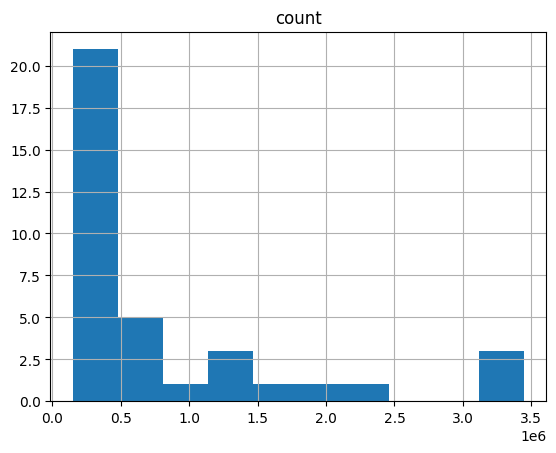

In [19]:
ent_df[ent_df['count'] > 150000].hist(column="count")

## Compute Discriminative Scores ##

In [ ]:
ent_df[ent_df[""]]
# take emb_w (each word)

## Compute Sentence Embeddings ##

In [103]:
def getSentenceEmb(text, emb_w, entropy):
    res = np.array([0.0] * 200)
    for word in text:
        if word not in entropy or word not in emb_w:
            continue
        res = np.add(res, np.array(entropy[word] * emb_w[word]))
    return res

In [108]:
doc_length = [len(d) for d in corpus]
print(min(doc_length), np.mean(doc_length), max(doc_length))

26 14388.628133850834 1307058


In [109]:
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))
def getGeoMean(sentenceEmb, topicEmbs):
    n = max(1, len(topicEmbs))
    temp = cos_sim(sentenceEmb, topicEmbs[0])
    for x in topicEmbs[1:]:
        temp *= cos_sim(sentenceEmb, x)
    # add a bias penality term for short documents in a corpus with on average long documents
    return np.power(np.abs(temp), (1/n)) + np.log(len(sentenceEmb)/np.mean(doc_length))

In [110]:
def getRankings(query, corpus, emb_w, emb_t, entropy, filename=None):
    res = []
    qTopics = []
    for x in query:
        qTopics.append(emb_t[x])
    for i, x in enumerate(corpus):
        s = getSentenceEmb(x.split(' '), emb_w, entropy[i])
        res.append((getGeoMean(s, qTopics), x))
    print(res)
    if filename is not None:
        with open(filename, 'w') as outfile:
            for x in res:
                outfile.write(str(x[0]) + '\t' + str(x[1]) + '\n')

# Load CatE Embeddings

In [111]:
folder = '/shared/data2/pk36/multidim/cate_data/bioWordVec/'
emb_age = readCateEmbeddings(folder + 'emb_study_w.txt')

In [112]:
topicEmbeddings = {}
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_age_t.txt'))
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_virus_t.txt'))
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_study_t.txt'))
topicEmbeddings.keys()

dict_keys(['elderly', 'adult', 'infant', 'coronavirus', 'sars', 'mers', 'ebola', 'origin', 'evolution', 'symptom', 'examination'])

In [113]:
corpus = []
with open('/shared/data2/pk36/multidim/cate_data/covid/covid_phrase_text_v2.txt', 'r') as infile:
    corpus = [s.strip() for s in list(infile.readlines())]

# Get Document Rankings

In [115]:
entropy = ent_df["tf_idf"]
entropy

words
!                          20.401928
'                           7.973257
''                         17.843782
''92                       10.261127
''abortion                 20.522254
                             ...    
zz_bnc_lp_d3_complexes     41.044508
zz_bncs                   441.228462
zzn                        73.300118
zzz                        52.623889
zzzproportion              10.261127
Name: tf_idf, Length: 440860, dtype: float64

In [116]:
qTest = ["coronavirus", "symptom", "infant"]
fname_result = "covid_symptom_infant_tf_idf.txt"
getRankings(qTest, corpus, emb_age, topicEmbeddings, entropy, None)

TypeError: argument of type 'numpy.float64' is not iterable

In [22]:
rankings = []
with open('covid_symptom_infant.txt', 'r') as infile:
    for line in infile.readlines():
        score, text = line.split('\t', 1)
        rankings.append((float(score), text))

In [23]:
rankings = sorted(rankings, key=lambda x: x[0], reverse=True)

In [26]:
rankings[0:1000][0]

(0.31712972510860965,
 'sars_cov_2 induced diarrhoea as onset symptom in patient with covid_19\n')

In [27]:
qTopics = []
for x in qTest:
    qTopics.append(topicEmbeddings[x])

In [29]:
def getAttentionWeights(text, emb_w, topicEmbs):
    res = []
    for x in topicEmbs:
        temp = []
        for word in text:
            if word not in emb_w:
                continue
            temp.append(cos_sim(emb_w[word], x))
        res.append(temp)
    return res

In [30]:
text = ["children hospitalized with upper and or lower respiratory_tract symptoms and or signs of rti"]
res = []
for i, x in enumerate(corpus):
    res.append((getAttentionWeights(text[0].split(' '), emb_age, qTopics), x))

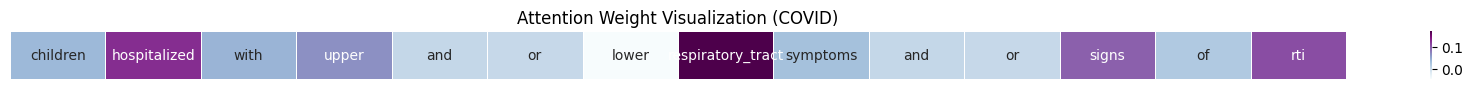

In [31]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][0]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(title='Attention Weight Visualization (COVID)')
ax.set(yticklabels=[])
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

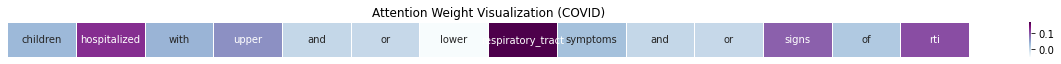

In [88]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][0]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(title='Attention Weight Visualization (COVID)')
ax.set(yticklabels=[])
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

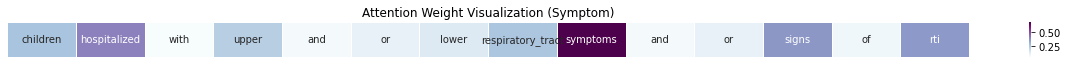

In [89]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][1]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Symptom)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

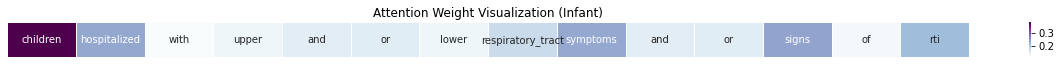

In [90]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][2]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Infant)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()